In [101]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [102]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati_profit.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)

#df = df.dropna(subset=['relative_quarterly_return'])

df.count()

datadate                          15175
tic                               15175
rdq                               15175
actq                              12966
epsfiq                            15101
teqq                               9611
dvpspq                            15144
PRC                               15021
spindx                            15175
ptb                                9548
div_yield                         15143
pe_inc                            15101
actq_change                       15174
epsfiq_change                     15160
teqq_change                       15065
dvpspq_change                     12089
ptb_change                        15065
div_yield_change                  12089
pe_inc_change                     15160
PRC_change                        15046
next_PRC_change                   15046
spindx_change                     15082
next_spindx_change                15082
relative_quarterly_return         15046
next_relative_quarterly_return    15046


In [103]:
df = df.dropna()
#df.info()

In [104]:
# Find the unique number of stocks in the dataframe
unique_stocks = df['tic'].unique()

# Print the result
print(f"Number of unique stocks: {len(unique_stocks)}")
print(unique_stocks)

df = df.sort_values(by=['datadate'])


Number of unique stocks: 79
['MA' 'CME' 'RTX' 'PFE' 'LMT' 'JCI' 'BA' 'XOM' 'ABT' 'OXY' 'FIS' 'CL'
 'CAT' 'BAX' 'LLY' 'ADM' 'JBL' 'MDT' 'FDX' 'F' 'EXPE' 'EQIX' 'SBUX' 'COP'
 'ETN' 'BMY' 'WDC' 'NVDA' 'CVX' 'PG' 'INTC' 'DIS' 'MU' 'STZ' 'NKE' 'TSN'
 'AAPL' 'MRK' 'QCOM' 'WBA' 'HCA' 'TGT' 'PPL' 'AMT' 'CVS' 'ZTS' 'GE' 'EXC'
 'VZ' 'MSFT' 'KO' 'CSCO' 'MCD' 'LUV' 'COST' 'UPS' 'T' 'HD' 'ECL' 'MMM' 'V'
 'AON' 'NOC' 'CTSH' 'SPGI' 'KMB' 'TMO' 'IBM' 'AMGN' 'MMC' 'UNH' 'WMT'
 'APD' 'AFL' 'JNJ' 'TSLA' 'PYPL' 'META' 'GOOGL']


In [105]:
#tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']
tickers_to_drop = ['RTX', 'EQIX', 'WBA', 'SCHW', 'ECL', 'AON', 'XOM', 'EXC', 'CVS', 'VZ', 'STZ', 'CVX', 'SPGI', ]

#df = df[~df['tic'].isin(tickers_to_drop)]

In [106]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

df = df.sort_values(by=['datadate'])

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

test_df = test_df.sort_values(by=['datadate', 'next_PRC_change'], ascending=[True, False])
test_df.head(10)


,datadate,tic,rdq,actq,epsfiq,teqq,dvpspq,PRC,spindx,ptb,...,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,PRC_change,next_PRC_change,spindx_change,next_spindx_change,relative_quarterly_return,next_relative_quarterly_return
11825,2013-03-31,WDC,2013-04-24,7340.0,1.600000,8423.0,0.0000,52.900000,1578.79,1.424744,...,-1.000000,0.152990,-1.000000,0.176471,0.123858,0.276560,0.056181,0.067868,0.067677,0.208691
9404,2013-03-31,TSN,2013-05-06,5299.0,0.260000,6114.0,0.0500,24.100000,1617.50,1.406658,...,-0.666667,0.157404,-0.714390,-0.458333,0.057018,0.231950,0.068948,0.055419,-0.011930,0.176531
8824,2013-03-31,MSFT,2013-04-18,93524.0,0.720000,76688.0,0.2300,28.790000,1541.61,3.102768,...,0.000000,-0.007199,-0.049603,-0.052632,0.041983,0.230983,0.031301,0.095848,0.010682,0.135135
11462,2013-03-31,NOC,2013-04-24,7846.0,2.030000,9469.0,0.5500,73.770000,1578.79,1.740641,...,0.000000,0.022073,-0.033825,-0.051402,0.111999,0.224075,0.051153,0.067868,0.060846,0.156206
8778,2013-03-31,LMT,2013-04-23,14872.0,2.330000,304.0,1.1500,97.060000,1578.78,98.810829,...,0.000000,-0.870935,-0.015297,0.346821,0.040858,0.214919,0.056167,0.071961,-0.015309,0.142958
10323,2013-03-31,JCI,2013-04-23,12826.0,0.251309,12032.0,0.0000,35.068063,1578.78,1.849821,...,-1.000000,0.123845,-1.000000,-0.538462,0.079974,0.207226,0.062450,0.070048,0.017524,0.137178
7884,2013-03-31,CME,2013-05-02,12297.8,0.710000,21555.8,0.4500,60.400000,1597.59,0.929604,...,-0.742857,0.099239,-0.767261,0.420000,0.020615,0.194868,0.057104,0.068403,-0.036488,0.126465
10972,2013-03-31,UNH,2013-04-18,22717.0,1.160000,31757.0,0.2125,59.690000,1541.61,1.855024,...,0.000000,0.054098,-0.074102,-0.033333,0.097243,0.181940,0.040967,0.095848,0.056275,0.086092
3961,2013-03-31,APD,2013-04-23,3379.2,1.380000,6517.4,0.6400,85.180000,1578.78,2.774582,...,0.000000,0.005644,-0.012366,0.053435,-0.036861,0.181615,0.056174,0.071961,-0.093036,0.109655
13606,2013-03-31,BA,2013-04-24,59490.0,1.440000,7560.0,0.4850,90.830000,1578.79,8.656261,...,0.102273,-0.095258,-0.034968,0.125000,0.217724,0.177474,0.051153,0.067868,0.166570,0.109606


In [107]:
results = test_df[['datadate', 'rdq', 'tic', 'next_PRC_change', 'next_relative_quarterly_return']].copy()

drop_cols = ['datadate', 'tic', 'rdq', 'spindx', 'spindx_change', 'next_spindx_change', 'PRC', 'PRC_change', 'next_PRC_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,actq,epsfiq,teqq,dvpspq,ptb,div_yield,pe_inc,actq_change,epsfiq_change,teqq_change,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,relative_quarterly_return,next_relative_quarterly_return
9429,2009.928,0.095000,4919.473,0.70,10.119448,0.019087,0.005938,-0.971345,-0.044025,-0.933976,0.000000,7.361167,-0.043854,-0.044025,-0.035313,-0.112417
5649,109.687,0.018543,68.418,0.20,16.142959,0.028571,0.000405,-0.992515,0.931818,-0.973021,0.000000,1.541880,0.000000,0.931818,-0.103921,-0.031253
4251,623.903,0.008542,601.056,0.20,210.787585,0.004983,0.000178,-0.924522,0.138889,-0.979495,0.333333,110.308120,0.338039,0.138889,-0.090388,0.021484
14009,458.928,0.015833,357.164,0.35,115.469355,0.005831,0.000330,-0.990440,-0.025641,-0.982583,0.000000,16.724700,-0.168471,-0.025641,0.185592,-0.031692
4876,1027.720,0.035833,1030.791,0.35,31.305088,0.007413,0.002986,-0.962807,-0.065217,0.004846,0.000000,-0.092305,0.096629,-0.065217,-0.080031,0.083710


In [108]:
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return',], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return',], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return',], 1)

X_train.head()

,actq,epsfiq,teqq,dvpspq,ptb,div_yield,pe_inc,actq_change,epsfiq_change,teqq_change,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,relative_quarterly_return
9429,2009.928,0.095000,4919.473,0.70,10.119448,0.019087,0.005938,-0.971345,-0.044025,-0.933976,0.000000,7.361167,-0.043854,-0.044025,-0.035313
5649,109.687,0.018543,68.418,0.20,16.142959,0.028571,0.000405,-0.992515,0.931818,-0.973021,0.000000,1.541880,0.000000,0.931818,-0.103921
4251,623.903,0.008542,601.056,0.20,210.787585,0.004983,0.000178,-0.924522,0.138889,-0.979495,0.333333,110.308120,0.338039,0.138889,-0.090388
14009,458.928,0.015833,357.164,0.35,115.469355,0.005831,0.000330,-0.990440,-0.025641,-0.982583,0.000000,16.724700,-0.168471,-0.025641,0.185592
4876,1027.720,0.035833,1030.791,0.35,31.305088,0.007413,0.002986,-0.962807,-0.065217,0.004846,0.000000,-0.092305,0.096629,-0.065217,-0.080031


In [109]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,epsfiq,teqq,dvpspq,ptb,div_yield,pe_inc,actq_change,epsfiq_change,teqq_change,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,relative_quarterly_return
0,0.018743,0.850151,0.049087,0.113821,0.020197,0.018463,0.994376,0.000927,0.553355,0.162828,0.185185,0.117384,0.092954,0.553355,0.121764
1,0.000457,0.847262,0.010763,0.032520,0.022238,0.027638,0.994368,0.000000,0.561420,0.162179,0.185185,0.067492,0.097217,0.561420,0.111597
2,0.005406,0.846884,0.014971,0.032520,0.088174,0.004820,0.994368,0.002977,0.554867,0.162071,0.246914,1.000000,0.130080,0.554867,0.113602
3,0.003818,0.847159,0.013044,0.056911,0.055885,0.005641,0.994368,0.000091,0.553507,0.162020,0.185185,0.197662,0.080839,0.553507,0.154501
4,0.009291,0.847915,0.018366,0.056911,0.027374,0.007171,0.994372,0.001301,0.553180,0.178442,0.185185,0.053481,0.106611,0.553180,0.115137


In [110]:
'''

model = xgb.XGBRanker(
    objective="rank:pairwise",  
    eval_metric="ndcg",
    learning_rate=0.05,
    max_depth=8,
    gamma=0.1,
    random_state=42,
    n_estimators=300
)

# Fit model with `group`
model.fit(X_train, y_train, group=train_group)

'''

'\n\nmodel = xgb.XGBRanker(\n    objective="rank:pairwise",  \n    eval_metric="ndcg",\n    learning_rate=0.05,\n    max_depth=8,\n    gamma=0.1,\n    random_state=42,\n    n_estimators=300\n)\n\n# Fit model with `group`\nmodel.fit(X_train, y_train, group=train_group)\n\n'

In [111]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [8],
    'gamma': [0.1],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[20:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.




/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[20:16:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[20:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[20:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[20:16:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[20:16:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.06996025098582807
CPU times: user 11.8 s, sys: 1.22 s, total: 13 s
Wall time: 3.77 s


In [112]:

%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)



CPU times: user 3.44 s, sys: 326 ms, total: 3.77 s
Wall time: 924 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

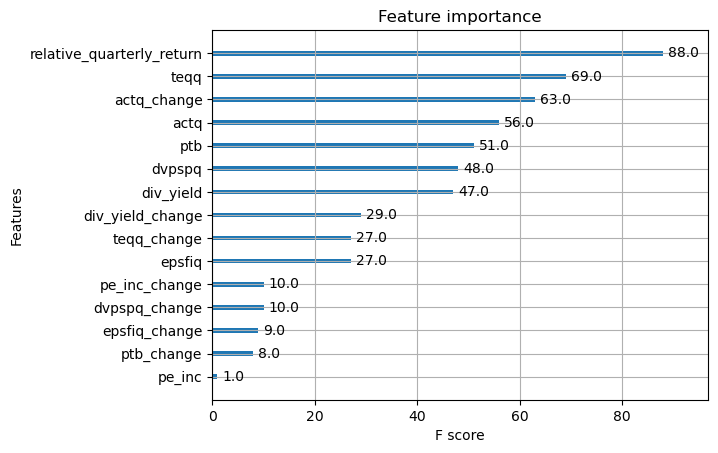

In [113]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [114]:
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_train_binary, y_train_pred_binary))



[0.00954498 0.00946417 0.00060222 ... 0.00947304 0.00214555 0.00553221]
              precision    recall  f1-score   support

           0       0.66      0.36      0.46      1512
           1       0.54      0.81      0.65      1439

    accuracy                           0.58      2951
   macro avg       0.60      0.58      0.56      2951
weighted avg       0.60      0.58      0.55      2951



In [115]:
results['y_pred'] = y_test_pred
results1 = results.sort_values(by=['datadate', 'y_pred'], ascending=[True, False])

results1.head(60)



,datadate,rdq,tic,next_PRC_change,next_relative_quarterly_return,y_pred
10269,2013-03-31,2013-05-02,HCA,-0.034346,-0.102749,1.826975
9607,2013-03-31,2013-03-12,COST,0.078361,0.012705,0.815908
7884,2013-03-31,2013-05-02,CME,0.194868,0.126465,0.193178
719,2013-03-31,2013-04-23,AAPL,0.031665,-0.040296,0.135691
8316,2013-03-31,2013-04-26,CVX,0.040903,-0.039635,0.113915
9381,2013-03-31,2013-04-18,IBM,-0.060825,-0.151186,0.038609
9874,2013-03-31,2013-04-19,MCD,-0.023419,-0.113616,0.017457
3930,2013-03-31,2013-04-25,EXPE,0.000462,-0.065834,0.014148
10323,2013-03-31,2013-04-23,JCI,0.207226,0.137178,0.012714
13606,2013-03-31,2013-04-24,BA,0.177474,0.109606,0.011547


In [116]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.0):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()


# Baseline aggregation remains unchanged.
df_avg = results.groupby('datadate').agg(
    stocks=('next_PRC_change', 'size'),
    baseline=('next_PRC_change', 'mean')
).reset_index()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_30'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_PRC_change',
        n=30,
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_20'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_PRC_change',
        n=20,
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_PRC_change',
        n=10,
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_5'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_PRC_change',
        n=5,
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_3'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_PRC_change',
        n=3,
        largest=True
    )
).reset_index(level=0, drop=True)

# For the ideal top 10, weight by the actual returns
df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_PRC_change',
        target_col='next_PRC_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_30,top_20,top_10,top_5,top_3,top_10_ideal
0,2013-03-31,65,0.062099,0.067689,0.067505,0.061237,0.062290,0.079628,0.212161
1,2013-06-30,58,0.048163,0.065482,0.083004,0.098987,0.082104,-0.028856,0.199155
2,2013-09-30,66,0.022972,0.027772,0.033053,0.031285,0.054653,-0.013227,0.203802
3,2013-12-31,66,0.172798,0.345190,0.484558,0.945328,1.791626,2.959190,1.011815
4,2014-03-31,65,0.040261,0.051080,0.050616,0.060139,0.101455,0.047657,0.146594
5,2014-06-30,65,0.013562,0.010655,0.002363,-0.010911,-0.051928,-0.075653,0.140549
6,2014-09-30,66,0.057451,0.054708,0.061971,0.034136,-0.000245,-0.050332,0.215443
7,2014-12-31,66,0.022863,0.046541,0.041989,0.031516,0.087408,0.108892,0.134613
8,2015-03-31,66,0.010390,0.029960,0.051191,0.100863,0.217829,0.353966,0.230165
9,2015-06-30,68,-0.012132,-0.019418,0.002363,-0.015259,0.003219,0.004239,0.126097


In [117]:
for portfolio in ['baseline', 'top_30', 'top_20', 'top_10', 'top_5', 'top_3']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.02989168509383673
Sharpe Ratio of the baseline portfolio: 0.09446901986286745

Mean quarterly return of the top_30 portfolio: 0.04056110592178598
Sharpe Ratio of the top_30 portfolio: 0.22884694465767214

Mean quarterly return of the top_20 portfolio: 0.04508402211589334
Sharpe Ratio of the top_20 portfolio: 0.23764701012254832

Mean quarterly return of the top_10 portfolio: 0.059265616277239225
Sharpe Ratio of the top_10 portfolio: 0.2262156122265192

Mean quarterly return of the top_5 portfolio: 0.07962437484590446
Sharpe Ratio of the top_5 portfolio: 0.19375030341606006

Mean quarterly return of the top_3 portfolio: 0.09259895906770706
Sharpe Ratio of the top_3 portfolio: 0.14584370660459922



In [118]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_30_cum_return'] = (1 + df_avg['top_30']).cumprod()
df_avg['top_20_cum_return'] = (1 + df_avg['top_20']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()
df_avg['top_5_cum_return'] = (1 + df_avg['top_5']).cumprod()
df_avg['top_3_cum_return'] = (1 + df_avg['top_3']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_30_value'] = initial_investment * df_avg['top_30_cum_return']
df_avg['top_20_value'] = initial_investment * df_avg['top_20_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']
df_avg['top_5_value'] = initial_investment * df_avg['top_5_cum_return']
df_avg['top_3_value'] = initial_investment * df_avg['top_3_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_30_value'],
                         mode='lines', name='Top 30 Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_20_value'],
                         mode='lines', name='Top 20 Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_5_value'],
                         mode='lines', name='Top 5 Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_3_value'],
                         mode='lines', name='Top 3 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()


In [119]:
results1 = results.sort_values(by=['rdq'], ascending=[True])
results1.head()

,datadate,rdq,tic,next_PRC_change,next_relative_quarterly_return,y_pred
13947,2013-03-31,2013-02-13,CSCO,0.003311,-0.087754,-0.001413
10066,2013-03-31,2013-02-19,MDT,0.143013,0.052729,0.003327
7952,2013-03-31,2013-02-21,WMT,0.117279,0.018738,-0.002739
9769,2013-03-31,2013-02-26,HD,0.165038,0.049990,0.006483
7492,2013-03-31,2013-02-27,TGT,0.083650,-0.008277,0.009429


In [120]:
filtered_results = results1[results1['y_pred'] > 0.05]
# Display the last 60 rows of the filtered dataframe
filtered_results.head(60)

,datadate,rdq,tic,next_PRC_change,next_relative_quarterly_return,y_pred
9607,2013-03-31,2013-03-12,COST,0.078361,0.012705,0.815908
719,2013-03-31,2013-04-23,AAPL,0.031665,-0.040296,0.135691
8316,2013-03-31,2013-04-26,CVX,0.040903,-0.039635,0.113915
10269,2013-03-31,2013-05-02,HCA,-0.034346,-0.102749,1.826975
7884,2013-03-31,2013-05-02,CME,0.194868,0.126465,0.193178
12328,2013-06-30,2013-05-21,MDT,0.009169,0.019240,0.227345
3112,2013-06-30,2013-07-17,IBM,-0.040195,-0.064367,0.150252
8249,2013-06-30,2013-07-25,LUV,0.232440,0.195866,0.052693
8780,2013-06-30,2013-08-02,CVX,-0.055542,-0.085940,0.115035
3824,2013-09-30,2013-10-16,IBM,0.009104,-0.061914,0.112053
